In [1]:
from google.colab import drive
import torch
drive.mount('/content/drive')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Mounted at /content/drive
Using device: cuda


当文件夹中的文件或子文件夹数量太多时，Google 云端硬盘操作可能会出现超时问题。如果有成千上万个项目直接包含在“我的云端硬盘”顶级文件夹中，那么装载该云端硬盘可能会超时。如果重复尝试，最后有可能会成功，因为在超时之前，失败的尝试会在本地缓存部分状态。如果您遇到此问题，请尝试将直接包含在“我的云端硬盘”中的文件和文件夹移至子文件夹。如果在 drive.mount() 运行成功后从其他文件夹中读取数据，可能会出现类似问题。访问含有许多项目的任何文件夹中的项目都可能会导致错误，例如 OSError: [Errno 5] Input/output error。同样，您只需将直接包含的项目移至子文件夹中，便可解决此问题。

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import shutil
import zipfile


In [3]:
# 源文件路径和目标目录
source_file = '/content/drive/MyDrive/Colab_Notebooks/crypko_data.zip'
destination_dir = '/content/sample_data'

# 复制zip文件到目标目录
shutil.copy(source_file, destination_dir)

# 解压缩文件
with zipfile.ZipFile(f'{destination_dir}/crypko_data.zip', 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("文件已成功复制并解压缩。")

文件已成功复制并解压缩。


In [4]:

# 设置随机种子
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)



In [5]:
# 自定义数据集类
class AnimeDataset(Dataset):
    def __init__(self, image_dir, transform=None, cache_file='file_list_cache.pkl'):
        self.image_dir = image_dir
        self.transform = transform
        self.cache_file = cache_file

        # 尝试从缓存文件加载文件列表
        if os.path.exists(self.cache_file):
            with open(self.cache_file, 'rb') as f:
                self.image_paths = pickle.load(f)
        else:
            self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('png', 'jpg', 'jpeg'))]
            with open(self.cache_file, 'wb') as f:
                pickle.dump(self.image_paths, f)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


In [6]:
# 数据增强和读取
data_dir = '/content/sample_data/faces'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),  # 数据增强：随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # 将值从 [0, 1] 映射到 [-1, 1]
])
dataset = AnimeDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)  # 使用多进程加速数据加载


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


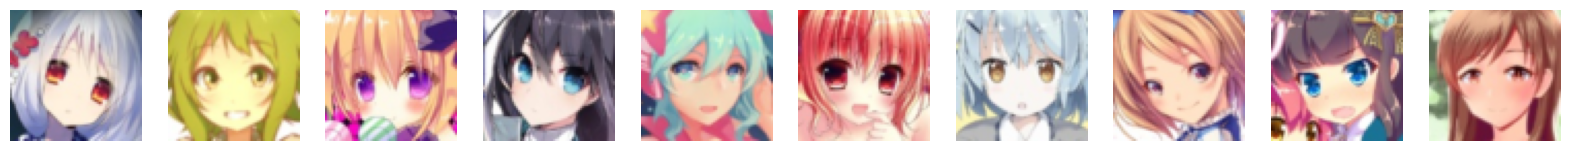

In [7]:
# 显示图片的函数
def show_images(images, num_images=10):
    images = (images + 1) / 2  # 将值从 [-1, 1] 移到 [0, 1]
    images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

# 获取一批数据并显示
dataiter = iter(dataloader)
images = next(dataiter)
show_images(images)

In [8]:
# 定义Generator和Discriminator类
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [11]:
# 定义超参数
nz = 100  # 潜在向量的维度
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = './content/drive/MyDrive/Colab Notebooks/training_checkpoints_v2'
os.makedirs(save_dir, exist_ok=True)

# 初始化模型
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# 固定的噪声用于生成图片
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 标签平滑
real_label = 0.9
fake_label = 0.1

In [12]:
# 训练循环
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # 更新判别器
        netD.zero_grad()
        real = data.to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # 更新生成器
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        # 保存生成的图片
        if (i % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            show_images(fake, 10)
            torch.save(netG.state_dict(), os.path.join(save_dir, f'netG_epoch_{epoch}.pth'))
            torch.save(netD.state_dict(), os.path.join(save_dir, f'netD_epoch_{epoch}.pth'))


Output hidden; open in https://colab.research.google.com to view.

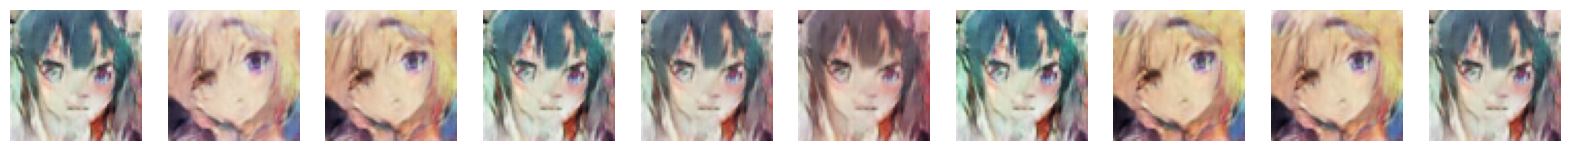

In [24]:
# 使用训练好的模型生成动漫面孔
netG.eval()
with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()

# 显示生成的图片
show_images(fake_images, 10)